### import modules

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.datasets import fetch_california_housing
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import kennard_stone as ks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns


### Constants & Variables
Set random_state for reproducibility.

In [2]:
SEED = 334
rng = np.random.RandomState(SEED)
rf = RandomForestRegressor(n_estimators=100, random_state=rng, n_jobs=-1)


### Sample data

The dataset of California house prices is too large and takes a long time to run, so we extracted as much data as that of Boston.

In [3]:
n_data = 506  # same as boston

california = fetch_california_housing()
X = pd.DataFrame(california["data"], columns=california["feature_names"])[
    :n_data
]
y = pd.Series(california["target"])[:n_data]
display(X.head(), y.head())


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
dtype: float64

## train_test_split

### scikit-learn
The randomness is so strong that I tried it 1000 times.

In [4]:
max_iter = 1000


In [5]:
scores = {
    "MSE": [],
    "R2": [],
}
for _iter in tqdm(range(max_iter)):
    X_train, X_test, y_train, y_test = ms.train_test_split(
        X, y, test_size=0.2, random_state=rng
    )
    rf.fit(X_train, y_train)
    y_pred_on_test = rf.predict(X_test)
    scores["MSE"].append(mse(y_test, y_pred_on_test))
    scores["R2"].append(r2_score(y_test, y_pred_on_test))


  0%|          | 0/1000 [00:00<?, ?it/s]

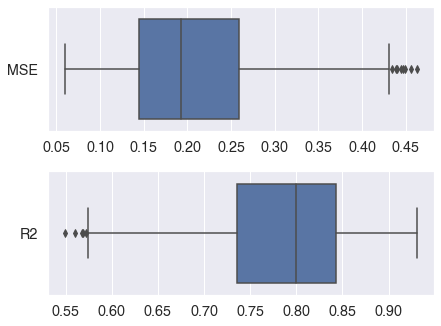

In [6]:
sns.set(style="darkgrid", font="Helvetica", font_scale=1.3)
fig = plt.figure(facecolor="white", figsize=(6.4, 4.8))
for i, score_name in enumerate(scores):
    ax = fig.add_subplot(2, 1, i + 1)
    sns.boxplot(
        ax=ax,
        data=pd.DataFrame(scores[score_name], columns=[score_name]),
        orient="h",
    )
fig.tight_layout()


In [7]:
sns.reset_defaults()


#### Average

In [8]:
for score_name, v in scores.items():
    print("{0}: {1:.3f}".format(score_name, np.average(v)))


MSE: 0.206
R2: 0.786


### Kennard Stone

In [9]:
X_train, X_test, y_train, y_test = ks.train_test_split(X, y, test_size=0.2)


In [10]:
rf = clone(rf)
rf.fit(X_train, y_train)
y_pred_on_test = rf.predict(X_test)


In [11]:
print("MSE: {:.3f}".format(mse(y_test, y_pred_on_test)))
print("R2: {:.3f}".format(r2_score(y_test, y_pred_on_test)))


MSE: 0.067
R2: 0.910


## cross_val_score

In [12]:
n_splits = 5
rf = clone(rf)


### scikit-learn

In [13]:
scores = {"MSE": [], "R2": []}
for i in tqdm(range(max_iter)):
    kf = ms.KFold(n_splits=5, random_state=rng, shuffle=True)
    cv = ms.cross_validate(
        rf, X, y, cv=kf, scoring=("neg_mean_squared_error", "r2")
    )
    scores["MSE"].append(cv["test_neg_mean_squared_error"].mean() * -1)
    scores["R2"].append(cv["test_r2"].mean())


  0%|          | 0/1000 [00:00<?, ?it/s]

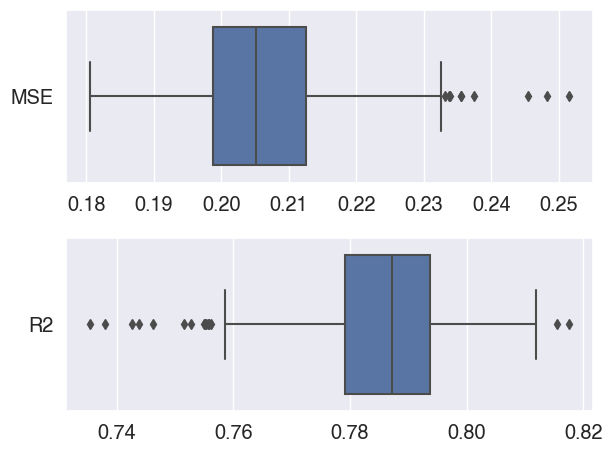

In [14]:
sns.set(style="darkgrid", font="Helvetica", font_scale=1.3)
fig = plt.figure(facecolor="white", figsize=(6.4, 4.8))
for i, score_name in enumerate(scores):
    ax = fig.add_subplot(2, 1, i + 1)
    sns.boxplot(
        ax=ax,
        data=pd.DataFrame(scores[score_name], columns=[score_name]),
        orient="h",
    )
fig.tight_layout()


In [15]:
sns.reset_defaults()


In [16]:
for score_name, v in scores.items():
    print("{0}: {1:.3f}".format(score_name, np.average(v)))


MSE: 0.206
R2: 0.786


### Kennard Stone

In [17]:
kf = ks.KFold(n_splits=5)
cv = ms.cross_validate(
    rf, X, y, cv=kf, scoring=("neg_mean_squared_error", "r2")
)
print("MSE: {:.3f}".format(-cv["test_neg_mean_squared_error"].mean()))
print("R2: {:.3f}".format(cv["test_r2"].mean()))


MSE: 0.193
R2: 0.801
